In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import numpy as np
import os
from torchvision import transforms
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt


### 划分验证集、测试集、训练集，并加入dataloader

In [2]:
# 从torchvision.datasets中加载FashionMNIST数据集
train_data = datasets.FashionMNIST(   #train_data很像一个生成器，逐步将数据加入
    root='../data',  # 数据存储路径
    train=True,   # 使用训练集
    download=True,  # 如果数据不存在则下载
    transform=ToTensor()  # 将图像转换为张量
)
# 计算训练集的均值和标准差
train_data_array = torch.stack([img for img, _ in train_data])  # 将训练集中的所有图像堆叠成一个大张量
mean = train_data_array.mean()  # 计算所有图像的平均值
std = train_data_array.std()    # 计算所有图像的标准差

train_data = datasets.FashionMNIST(  
    root='../data',  # 数据存储路径
    train=True,   # 使用训练集
    download=True,  # 如果数据不存在则下载
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((mean,), (std,))
    ])  # 将图像转换为张量并标准化
)


# 计算训练集和验证集的样本数
train_size = 55000
val_size =5000

# 使用random_split函数将数据集划分为训练集和验证集
train_dataset, val_dataset = random_split(
    train_data, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # 设置随机种子以确保可重复性
)




# 加载测试数据集
test_dataset = datasets.FashionMNIST(
    root='../data',  # 指定数据存储路径
    train=False,  # 使用测试集
    download=True,  # 如果数据不存在则下载
    transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((mean,), (std,))])
)


# 设置批次大小
batch_size = 64

# 创建数据加载器
train_loader = DataLoader(
    train_dataset,  # 训练数据集
    batch_size=batch_size,  # 每批次的样本数
    shuffle=True  # 随机打乱数据
)

val_loader = DataLoader(
    val_dataset,  # 验证数据集
    batch_size=batch_size,
    shuffle=False  # 验证集不需要打乱
)

test_loader = DataLoader(
    test_dataset,  # 测试数据集
    batch_size=batch_size,
    shuffle=False  # 测试集不需要打乱
)


In [3]:
# # 在测试集上评估模型
# test_loss, test_accuracy = evaluate_model(model, test_loader, device, criterion)

# print(f'\n测试集结果:')
# print(f'平均损失: {test_loss:.4f}')
# print(f'准确率: {test_accuracy:.2f}%')


### 搭建神经网络类

In [4]:
import torch
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self,):
        super().__init__()
        # 构建三个隐藏层的神经网络
        # 输入层到第一个隐藏层: 784 (28*28) -> 128
        self.hidden1 = nn.Linear(28*28, 128)
        # 第一个隐藏层到第二个隐藏层: 128 -> 64
        self.hidden2 = nn.Linear(128, 64)
        # 第二个隐藏层到输出层: 64 -> 10 (10个类别)
        self.hidden3 = nn.Linear(64, 10)
        # 定义ReLU激活函数,用于在神经网络中引入非线性变换
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        # 将输入张量展平为一维向量
        # 将输入张量重塑为(batch_size, 784)的形状，其中784=28*28是输入图像的像素总数
        x = x.view(-1, 1*28 * 28)
        # 前向传播
        # 通过第一个隐藏层，应用ReLU激活函数
        x = self.relu(self.hidden1(x))
        # 通过第二个隐藏层，应用ReLU激活函数
        x = self.relu(self.hidden2(x))
        # 通过第三个隐藏层，得到最终输出
        x = self.hidden3(x)
        # 返回神经网络的输出结果
        return x


### 设置损失函数和优化器，以及用cpu还是GPU

In [5]:
model=NeuralNetwork()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
# 定义损失函数为交叉熵损失
# 定义损失函数为交叉熵损失
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数用于多分类问题:
                                 # 1. 它将模型输出的logits转换为概率分布(通过softmax)
                                 # 2. 计算预测概率分布与真实标签之间的交叉熵
                                 # 3. 自动处理数值稳定性问题
                                 # 4. 输出一个标量损失值,用于反向传播优化模型

# 定义优化器为Adam，学习率设为0.001
optimizer = torch.optim.SGD(model.parameters(), lr=0.001,momentum=0.9,nesterov=True)#momentum意思：动量，表示在更新参数时，考虑之前的梯度信息，以加速收敛


In [6]:
# # 在测试集上评估模型
# test_loss, test_accuracy = evaluate_model(model, test_loader, device, criterion)

# print(f'\n测试集结果:')
# print(f'平均损失: {test_loss:.4f}')
# print(f'准确率: {test_accuracy:.2f}%')


### 计算模型的参数量

####  类里有call方法时，创建的对象可以（）有参数

In [7]:
def count_parameters(model):
    """计算模型的总参数量和每层参数量"""
    # 使用nn.Module的方法获取参数量
    total_params = 0
    
    # 遍历模型的所有命名参数
    for name, parameter in model.named_parameters():
        param_count = parameter.numel()
        total_params += param_count
        # 打印每层的参数名称、形状和参数量
        print(f'层: {name}',end=', ')
        print(f'参数量: {param_count:,}')
        # 如果是权重层，检查是否有对应的bias
        if 'weight' in name:
            bias_name = name.replace('weight', 'bias')
    
    return total_params

# 打印模型总参数量
total_parameters = count_parameters(model)
print(f'模型总参数量: {total_parameters:,}')


层: hidden1.weight, 参数量: 100,352
层: hidden1.bias, 参数量: 128
层: hidden2.weight, 参数量: 8,192
层: hidden2.bias, 参数量: 64
层: hidden3.weight, 参数量: 640
层: hidden3.bias, 参数量: 10
模型总参数量: 109,386


### 评估函数

In [8]:
def evaluate_model(model, data_loader, device, criterion=None):  # 定义评估函数,接收模型、数据加载器、设备和损失函数作为参数
    """
    评估神经网络模型的性能
    
    参数:
    model: 训练好的神经网络模型
    data_loader: 数据加载器,包含测试数据
    device: 运行设备 ('cpu' 或 'cuda')
    criterion: 损失函数
    
    返回:
    accuracy: 模型准确率
    loss: 模型损失值 (如果未提供criterion则返回None)
    """
    model.eval()  # 设置为评估模式
    total_loss = 0  # 初始化总损失为0
    total_correct = 0  # 初始化总正确预测数为0
    total_samples = 0  # 初始化总样本数为0
    
    with torch.no_grad():  # 关闭梯度计算以节省内存
        for batch_data, batch_labels in data_loader:  # 遍历数据加载器中的每个批次
            batch_data = batch_data.to(device)  # 将输入数据转移到指定设备
            batch_labels = batch_labels.to(device)  # 将标签数据转移到指定设备
            
            outputs = model(batch_data)  # 通过模型进行前向传播得到输出
            
            if criterion is not None:  # 如果提供了损失函数
                loss = criterion(outputs, batch_labels)  # 计算当前批次的损失
                total_loss += loss.item() * batch_data.size(0)  # 累加损失值乘以批次大小
            
            _, predicted = torch.max(outputs, 1)  # 获取每个样本的预测类别
            total_correct += (predicted == batch_labels).sum().item()  # 计算正确预测的样本数
            total_samples += batch_labels.size(0)  # 累加样本总数，考虑最后一个batch可能比较小
    
    accuracy = 100 * total_correct / total_samples  # 计算总体准确率，使用实际样本数作为分母
   
    
    if criterion is not None:  # 如果计算了损失值
        loss = total_loss / total_samples  # 使用实际样本数计算平均损失，考虑最后一个batch可能比较小
        return accuracy, loss
    else:
        return accuracy  # 只返回准确率


### 早停类

In [9]:
class EarlyStopping:
    """早停机制
    
    当验证集性能不再提升时，及时停止训练，防止过拟合
    
    参数:
        patience: 容忍验证集性能不提升的轮数
        min_delta: 验证集性能提升的最小变化值，小于此值视为没有提升
        mode: 监控模式，'min'表示监控指标越小越好，'max'表示越大越好
    """
    def __init__(self, patience=7, min_delta=0.0001):
        self.patience = patience  # 设置容忍的轮数
        self.min_delta = min_delta  # 设置性能提升的最小变化阈值
        
        self.counter = 0  # 初始化计数器
        self.best_accuracy = float('-inf')  # 初始化最佳准确率float('-inf')负无穷
        self.early_stop = False  # 初始化早停标志
    
    def __call__(self, current_accuracy):
        if current_accuracy > self.best_accuracy + self.min_delta:  # 如果当前准确率比最佳准确率加上阈值还高
            self.best_accuracy = current_accuracy  # 更新最佳准确率
            self.counter = 0  # 重置计数器
        else:  # 如果准确率没有显著提升
            self.counter += 1  # 计数器加1
                
        if self.counter >= self.patience:  # 如果计数器达到容忍轮数
            self.early_stop = True  # 设置早停标志为True
            
        return self.early_stop  # 返回早停标志


### 模型保存

In [10]:
class ModelSaver:
    """模型保存类
    
    保存训练过程中的模型参数
    
    参数:
        save_mode: 保存模式，'all'表示保存每一轮的模型，'best'表示只保存最佳模型
    """
    def __init__(self, save_mode='best'):
        self.save_mode = save_mode  # 设置模型保存模式，默认为'best'只保存最佳模型
        self.best_accuracy = float('-inf')  # 初始化最佳准确率为负无穷，确保第一次一定会更新
        self.best_model_state = None  # 初始化用于存储最佳模型参数的变量为空
        # 判断保存模型的文件夹是否存在，如果不存在则创建
        if not os.path.exists('model'):
            os.makedirs('model')
        
    def __call__(self, model, current_accuracy, epoch=None):
        if self.save_mode == 'all' and epoch is not None:  # 如果是保存所有模型的模式且提供了epoch参数
            # 保存每一轮的模型到model文件夹
            save_path = os.path.join('model', f'model_epoch_{epoch}.pth')
            torch.save(model.state_dict(), save_path)  # 将当前轮次的模型参数保存到文件中
            
        if current_accuracy > self.best_accuracy:  # 判断当前准确率是否高于历史最佳准确率
            self.best_accuracy = current_accuracy  # 更新最佳准确率记录
            self.best_model_state = model.state_dict()  # 保存当前模型的参数作为最佳模型
            if self.save_mode == 'best':  # 如果是只保存最佳模型的模式
                self.save_best_model()  # 调用保存最佳模型的方法
            
    def save_best_model(self, path='best_model.pth'):
        """保存最佳模型到文件
        
        参数:
            path: 保存模型的路径，默认为'best_model.pth'
        """
        if self.best_model_state is not None:  # 确保最佳模型参数不为空
            save_path = os.path.join('model', path)  # 将模型保存到model文件夹下
            torch.save(self.best_model_state, save_path)  # 将最佳模型参数保存到指定路径


### 模型训练函数


In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=20,early_stopping=None,model_saver=None):
    """
    训练神经网络模型
    
    参数:
        model: 神经网络模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        criterion: 损失函数
        optimizer: 优化器
        epochs: 训练轮数, 默认50
        device: 训练设备(CPU/GPU)
        early_stopping: 早停法参数，包含patience和min_delta
       
    
    返回:
        history: 训练历史记录，包含损失值、准确率等指标
    """
    history = {
    'train_loss': [],           # 训练集损失
    'val_loss': [],       # 验证集损失
    'train_accuracy': [],       # 训练集准确率
    'val_accuracy': [],   # 验证集准确率
    'step': [],           # 记录训练步数
    }
    
    # 计算总迭代次数用于进度条显示
    total_iterations = len(train_loader) * epochs  # 计算总迭代次数
    
    # 使用tqdm创建进度条，显示总体训练进度
    pbar = tqdm(total=total_iterations, desc='Training Progress')
    
    step_counter = 0  # 初始化步数计数器
    
    for epoch in range(epochs):
        # 训练阶段
        model.train()  # 设置模型为训练模式
        running_loss = 0.0  # 初始化运行损失
        correct = 0  # 初始化正确预测数
        total = 0  # 初始化总样本数
        
        for i, (inputs, targets) in enumerate(train_loader):
            step_counter += 1  # 每处理一个批次，步数加1
            batch_size = inputs.size(0)  # 获取当前批次的实际大小，考虑最后一个batch可能较小
            inputs, targets = inputs.to(device), targets.to(device)  # 将数据移至指定设备
            
            # 清零梯度
            optimizer.zero_grad()  # 清除之前的梯度
            
            # 前向传播
            outputs = model(inputs)  # 获取模型输出
            # 计算损失值
            loss = criterion(outputs, targets)  # 计算当前批次的损失
            
            # 反向传播
            loss.backward()  # 计算梯度
            optimizer.step() # 更新模型参数
            
            # 统计
            running_loss += loss.item() * batch_size  # 累加每个batch的损失值乘以批次大小
            _, predicted = outputs.max(1)  # 获取预测结果
            total += batch_size  # 累加样本总数
            correct += predicted.eq(targets).sum().item()  # 累加正确预测数
            
            # 计算当前批次的训练准确率和损失
            batch_accuracy = 100. * correct / total
            batch_loss = running_loss / total  # 使用总样本数而不是批次数
            
            # 更新进度条信息，显示当前批次的训练损失和准确率
            pbar.set_postfix({
                'epoch': f'{epoch+1}/{epochs}',  # 显示当前轮次和总轮次
                'train_loss': f'{batch_loss:.4f}',  # 显示训练损失
                'train_acc': f'{batch_accuracy:.2f}%',  # 显示训练准确率
                'val_loss': f'{val_loss:.4f}' if epoch > 0 else 'N/A',  # 显示验证集损失（第一轮前显示N/A）
                'val_acc': f'{val_accuracy:.2f}%' if epoch > 0 else 'N/A'  # 显示验证集准确率（第一轮前显示N/A）
            })
            pbar.update(1)  # 更新进度条
                
        train_accuracy = 100. * correct / total  # 计算整个训练集的准确率
        train_loss = running_loss / total  # 计算整个训练集的平均损失，使用总样本数
        
        # 验证阶段
        val_accuracy, val_loss = evaluate_model(model, val_loader, device, criterion)  # 评估模型在验证集上的表现
        
    
        # 记录训练和验证指标
        history['train_loss'].append(train_loss)  # 记录训练损失到历史记录中
        history['val_loss'].append(val_loss)  # 记录验证损失到历史记录中
        history['train_accuracy'].append(train_accuracy)  # 记录训练准确率到历史记录中
        history['val_accuracy'].append(val_accuracy)  # 记录验证准确率到历史记录中
        history['step'].append(step_counter)  # 记录当前步数到历史记录中
        
         # 如果有模型保存器，保存模型
        if model_saver is not None:
            model_saver(model, val_accuracy, epoch)  # 保存当前模型
        
        # 如果有早停器，检查是否应该早停
        if early_stopping is not None:
            early_stopping(val_accuracy)  # 使用验证准确率而不是验证损失
            if early_stopping.early_stop:
                print(f'早停: 已有{early_stopping.patience}轮验证损失没有改善！')
                break
    
    pbar.close()  # 关闭进度条
    return model,history


In [12]:
early_stopping=EarlyStopping(patience=5, min_delta=0.01) 
model_saver=ModelSaver(save_mode='best')
model_train, history = train_model(model, train_loader, val_loader, criterion, optimizer, device,epochs=50,early_stopping=early_stopping,model_saver=model_saver)

Training Progress:   0%|          | 0/43000 [00:00<?, ?it/s]

早停: 已有5轮验证损失没有改善！


In [13]:
# 导入绘图库


def plot_learning_curves(history, sample_step=500):
    """
    绘制训练历史图表
    
    Args:
        history (dict): 包含训练历史数据的字典，需要包含'step', 'train_accuracy', 'val_accuracy', 'train_loss', 'val_loss'键
        sample_step (int): 采样步长，用于控制绘图点的密度
    """
    # 创建一个图形，包含两个子图，宽度为12，高度为4
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 创建一个包含两个子图的图形
    
    # 根据sample_step对数据进行采样
    indices = range(0, len(history['step']), max(1, len(history['step']) // sample_step))  # 根据sample_step计算采样索引
    sampled_steps = [history['step'][i] for i in indices]  # 采样步数数据
    sampled_train_acc = [history['train_accuracy'][i] for i in indices]  # 采样训练准确率数据
    sampled_val_acc = [history['val_accuracy'][i] for i in indices]  # 采样验证准确率数据
    sampled_train_loss = [history['train_loss'][i] for i in indices]  # 采样训练损失数据
    sampled_val_loss = [history['val_loss'][i] for i in indices]  # 采样验证损失数据
    
    # 将步数转换为以1000为单位的值（1k）
    steps_in_k = [step/1000 for step in sampled_steps]  # 将采样后的步数转换为以k为单位
    
    # 在第一个子图中绘制准确率曲线，不带标记点
    ax1.plot(steps_in_k, sampled_train_acc, label='Training Accuracy', linestyle='-')  # 绘制训练准确率曲线，不带标记点
    ax1.plot(steps_in_k, sampled_val_acc, label='Validation Accuracy', linestyle='-')  # 绘制验证准确率曲线，不带标记点
    ax1.set_xlabel('Steps')  # 设置x轴标签
    ax1.set_ylabel('Accuracy (%)')  # 设置y轴标签为英文
    ax1.set_title('Training and Validation Accuracy')  # 设置图表标题
    ax1.legend()  # 显示图例
    ax1.grid(True)  # 显示网格
    
    # 在第二个子图中绘制损失曲线，不带标记点
    ax2.plot(steps_in_k, sampled_train_loss, label='Training Loss', linestyle='-')  # 绘制训练损失曲线，不带标记点
    ax2.plot(steps_in_k, sampled_val_loss, label='Validation Loss', linestyle='-')  # 绘制验证损失曲线，不带标记点
    ax2.set_xlabel('Steps ')  # 设置x轴标签
    ax2.set_ylabel('Loss')  # 设置y轴标签为英文
    ax2.set_title('Training and Validation Loss')  # 设置图表标题
    ax2.legend()  # 显示图例
    ax2.grid(True)  # 显示网格
    
    # 设置x轴刻度标签格式，添加"k"后缀
    ax1.xaxis.set_major_formatter(lambda x, pos: f'{x:.0f}k')  # 为第一个子图的x轴添加"k"后缀
    ax2.xaxis.set_major_formatter(lambda x, pos: f'{x:.0f}k')  # 为第二个子图的x轴添加"k"后缀
    
    plt.tight_layout()  # 调整子图布局
    plt.show()  # 直接显示图形而不是返回


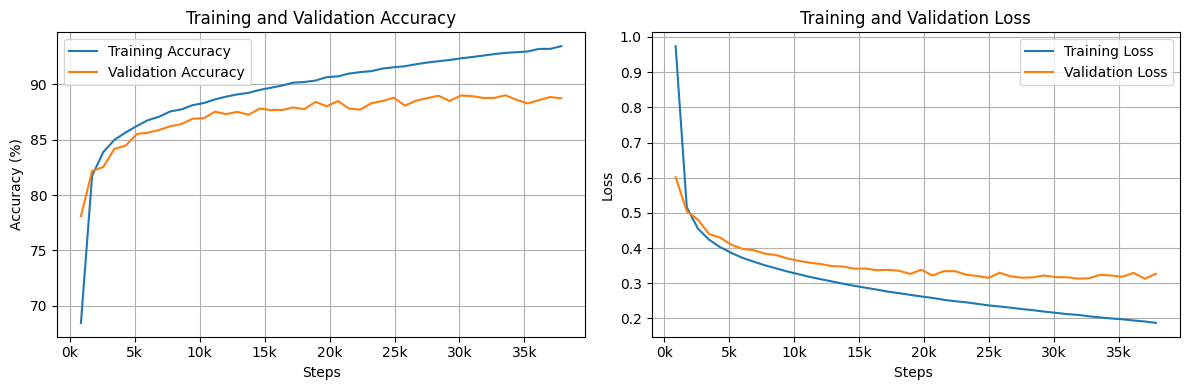

In [14]:
# 调用函数绘制学习曲线
his=history.copy()
plot_learning_curves(his,sample_step=500)

In [15]:
# 在测试集上评估模型
test_accuracy,test_loss  = evaluate_model(model, test_loader, device, criterion)

print(f'\n测试集结果:')
print(f'平均损失: {test_loss:.4f}')
print(f'准确率: {test_accuracy:.2f}%')



测试集结果:
平均损失: 0.3442
准确率: 88.38%
